# Import Necessary Library

In [1]:
import time
from haversine_script import *
import numpy as np
import tensorflow as tf
import random
import pandas as p
import math
import matplotlib.pyplot as plt
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

Using TensorFlow backend.


# Dataset Preprocessing Functions

In [2]:
def get_exponential_distance(x,minimum,a=60):
	positive_x= x-minimum
	numerator = np.exp(positive_x.div(a))
	denominator = np.exp(-minimum/a)
	exponential_x = numerator/denominator
	exponential_x = exponential_x * 1000  #facilitating calculations
	final_x = exponential_x
	return final_x

In [3]:
def get_powed_distance(x,minimum,b=1.1):
	positive_x= x-minimum
	numerator = positive_x.pow(b)
	denominator = (-minimum)**(b)
	powed_x = numerator/denominator
	final_x = powed_x
	return final_x

# Python Random Seeding for experiment reproducibility

In [4]:
os.environ['PYTHONHASHSEED'] = "42"
np.random.seed(42)
tf.set_random_seed(42)
random.seed(42)

In [5]:

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Loading Dataset

In [6]:
# reading the data
file = p.read_csv('lorawan_antwerp_2019_dataset.csv')
columns = file.columns
# x = file[columns[0:68]]
# y = file[columns[71:]]
x = file[columns[0:72]]
x = x.join(file[columns[73]])
y = file[columns[72:]]


Dataset Preprocessing

In [7]:
x = x.replace(-200,200)
minimum = x.min().min() - 1
x = x.replace(200,minimum)
print('minimum')
print(minimum)

minimum
-128.0


RSSI Data representation using Powed Function


In [8]:
final_x = get_powed_distance(x,minimum)

In [9]:
random_state = 42
x_train, x_test_val, y_train, y_test_val = train_test_split(final_x.values, y.values, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(91300, 73)
(19564, 73)
(19565, 73)


In [10]:
n_of_features = x_train.shape[1]

scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


scaler_y = preprocessing.MinMaxScaler().fit(y_train)
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


# Network HyperParameters

In [11]:
dropout = 0.15
l2 = 0.00
lr = 0.0005
epochs = 10000
batch_size= 512
patience = 300

# Define the MLP Network

In [12]:
model = Sequential()
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
#model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
#model.add(Dense(units=256, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
#model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout, seed=random_state))
#model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
# model.add(Dropout(dropout))
model.add(Dense(units=2))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=lr))

W1124 17:42:00.995769 38156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1124 17:42:00.999759 38156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1124 17:42:01.004745 38156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1124 17:42:01.180289 38156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorfl

In [13]:
cb =[EarlyStopping(monitor='val_loss', patience=patience, verbose =1, restore_best_weights=True)]
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks= cb)


W1124 17:42:02.230534 38156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 91300 samples, validate on 19564 samples
Epoch 1/10000
91300/91300 [==============================] - 6s 63us/step - loss: 0.2139 - val_loss: 0.1748
Epoch 2/10000
91300/91300 [==============================] - 4s 44us/step - loss: 0.0947 - val_loss: 0.0864
Epoch 3/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0683 - val_loss: 0.0609
Epoch 4/10000
91300/91300 [==============================] - 4s 48us/step - loss: 0.0574 - val_loss: 0.0586
Epoch 5/10000
91300/91300 [==============================] - 5s 59us/step - loss: 0.0528 - val_loss: 0.0541
Epoch 6/10000
91300/91300 [==============================] - 5s 60us/step - loss: 0.0496 - val_loss: 0.0637
Epoch 7/10000
91300/91300 [==============================] - 5s 53us/step - loss: 0.0462 - val_loss: 0.0436
Epoch 8/10000
91300/91300 [==============================] - 6s 61us/step - loss: 0.0476 - val_loss: 0.0415
Epoch 9/10000
91300/91300 [==============================] - 5s 56us/step - loss: 0.04

91300/91300 [==============================] - 3s 37us/step - loss: 0.0273 - val_loss: 0.0313
Epoch 76/10000
91300/91300 [==============================] - 3s 36us/step - loss: 0.0259 - val_loss: 0.0290
Epoch 77/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0272 - val_loss: 0.0314
Epoch 78/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0270 - val_loss: 0.0298
Epoch 79/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0273 - val_loss: 0.0307
Epoch 80/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0257 - val_loss: 0.0335
Epoch 81/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0252 - val_loss: 0.0329
Epoch 82/10000
91300/91300 [==============================] - 3s 36us/step - loss: 0.0260 - val_loss: 0.0288
Epoch 83/10000
91300/91300 [==============================] - 3s 36us/step - loss: 0.0266 - val_loss: 0.0302
Epoch 84/10000
91300/91300 [======

Epoch 150/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0226 - val_loss: 0.0239
Epoch 151/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0237 - val_loss: 0.0208
Epoch 152/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0239 - val_loss: 0.0226
Epoch 153/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0212 - val_loss: 0.0192
Epoch 154/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0227 - val_loss: 0.0193
Epoch 155/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0226 - val_loss: 0.0235
Epoch 156/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0246 - val_loss: 0.0214
Epoch 157/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0238 - val_loss: 0.0239
Epoch 158/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0235 - val_loss: 0.0218
Epoch 159/

91300/91300 [==============================] - 4s 49us/step - loss: 0.0211 - val_loss: 0.0193
Epoch 225/10000
91300/91300 [==============================] - 4s 44us/step - loss: 0.0211 - val_loss: 0.0219
Epoch 226/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0208 - val_loss: 0.0230
Epoch 227/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0211 - val_loss: 0.0193
Epoch 228/10000
91300/91300 [==============================] - 4s 48us/step - loss: 0.0197 - val_loss: 0.0287
Epoch 229/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0214 - val_loss: 0.0236
Epoch 230/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0209 - val_loss: 0.0232
Epoch 231/10000
91300/91300 [==============================] - 4s 48us/step - loss: 0.0205 - val_loss: 0.0183
Epoch 232/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0205 - val_loss: 0.0230
Epoch 233/10000
91300/9130

91300/91300 [==============================] - 4s 41us/step - loss: 0.0196 - val_loss: 0.0204
Epoch 299/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0198 - val_loss: 0.0193
Epoch 300/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0187 - val_loss: 0.0182
Epoch 301/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0188 - val_loss: 0.0174
Epoch 302/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0186 - val_loss: 0.0240
Epoch 303/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0194 - val_loss: 0.0204
Epoch 304/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0188 - val_loss: 0.0211
Epoch 305/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0190 - val_loss: 0.0172
Epoch 306/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0183 - val_loss: 0.0194
Epoch 307/10000
91300/9130

91300/91300 [==============================] - 4s 47us/step - loss: 0.0187 - val_loss: 0.0197
Epoch 373/10000
91300/91300 [==============================] - 4s 48us/step - loss: 0.0172 - val_loss: 0.0181
Epoch 374/10000
91300/91300 [==============================] - 4s 48us/step - loss: 0.0179 - val_loss: 0.0162
Epoch 375/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0180 - val_loss: 0.0173
Epoch 376/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0176 - val_loss: 0.0187
Epoch 377/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0182 - val_loss: 0.0180
Epoch 378/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0178 - val_loss: 0.0178
Epoch 379/10000
91300/91300 [==============================] - 4s 46us/step - loss: 0.0176 - val_loss: 0.0171
Epoch 380/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0180 - val_loss: 0.0188
Epoch 381/10000
91300/9130

91300/91300 [==============================] - 4s 44us/step - loss: 0.0176 - val_loss: 0.0176
Epoch 447/10000
91300/91300 [==============================] - 4s 44us/step - loss: 0.0170 - val_loss: 0.0182
Epoch 448/10000
91300/91300 [==============================] - 6s 61us/step - loss: 0.0174 - val_loss: 0.0199
Epoch 449/10000
91300/91300 [==============================] - 5s 59us/step - loss: 0.0173 - val_loss: 0.0167
Epoch 450/10000
91300/91300 [==============================] - 5s 54us/step - loss: 0.0169 - val_loss: 0.0198
Epoch 451/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0172 - val_loss: 0.0169
Epoch 452/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0170 - val_loss: 0.0168
Epoch 453/10000
91300/91300 [==============================] - 4s 46us/step - loss: 0.0169 - val_loss: 0.0156
Epoch 454/10000
91300/91300 [==============================] - 4s 47us/step - loss: 0.0169 - val_loss: 0.0186
Epoch 455/10000
91300/9130

91300/91300 [==============================] - 4s 45us/step - loss: 0.0159 - val_loss: 0.0171
Epoch 521/10000
91300/91300 [==============================] - 4s 47us/step - loss: 0.0162 - val_loss: 0.0166
Epoch 522/10000
91300/91300 [==============================] - 4s 46us/step - loss: 0.0162 - val_loss: 0.0170
Epoch 523/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0161 - val_loss: 0.0177
Epoch 524/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0168 - val_loss: 0.0189
Epoch 525/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0163 - val_loss: 0.0156
Epoch 526/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0165 - val_loss: 0.0199
Epoch 527/10000
91300/91300 [==============================] - 4s 47us/step - loss: 0.0158 - val_loss: 0.0164
Epoch 528/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0160 - val_loss: 0.0177
Epoch 529/10000
91300/9130

91300/91300 [==============================] - 4s 39us/step - loss: 0.0153 - val_loss: 0.0158
Epoch 595/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0158 - val_loss: 0.0170
Epoch 596/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0157 - val_loss: 0.0183
Epoch 597/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0160 - val_loss: 0.0205
Epoch 598/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0156 - val_loss: 0.0162
Epoch 599/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0159 - val_loss: 0.0184
Epoch 600/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0162 - val_loss: 0.0154
Epoch 601/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0161 - val_loss: 0.0195
Epoch 602/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0157 - val_loss: 0.0165
Epoch 603/10000
91300/9130

91300/91300 [==============================] - 4s 39us/step - loss: 0.0154 - val_loss: 0.0192
Epoch 669/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0153 - val_loss: 0.0161
Epoch 670/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0154 - val_loss: 0.0156
Epoch 671/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0153 - val_loss: 0.0166
Epoch 672/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0158 - val_loss: 0.0168
Epoch 673/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0152 - val_loss: 0.0177
Epoch 674/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0155 - val_loss: 0.0164
Epoch 675/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0152 - val_loss: 0.0164
Epoch 676/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0152 - val_loss: 0.0163
Epoch 677/10000
91300/9130

91300/91300 [==============================] - 4s 48us/step - loss: 0.0146 - val_loss: 0.0160
Epoch 743/10000
91300/91300 [==============================] - 4s 48us/step - loss: 0.0146 - val_loss: 0.0159
Epoch 744/10000
91300/91300 [==============================] - 4s 49us/step - loss: 0.0150 - val_loss: 0.0174
Epoch 745/10000
91300/91300 [==============================] - 5s 52us/step - loss: 0.0152 - val_loss: 0.0169
Epoch 746/10000
91300/91300 [==============================] - 4s 49us/step - loss: 0.0147 - val_loss: 0.0161
Epoch 747/10000
91300/91300 [==============================] - 4s 49us/step - loss: 0.0154 - val_loss: 0.0173
Epoch 748/10000
91300/91300 [==============================] - 5s 50us/step - loss: 0.0148 - val_loss: 0.0183
Epoch 749/10000
91300/91300 [==============================] - 5s 49us/step - loss: 0.0149 - val_loss: 0.0161
Epoch 750/10000
91300/91300 [==============================] - 5s 54us/step - loss: 0.0150 - val_loss: 0.0156
Epoch 751/10000
91300/9130

91300/91300 [==============================] - 3s 38us/step - loss: 0.0146 - val_loss: 0.0156
Epoch 817/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0146 - val_loss: 0.0185
Epoch 818/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0148 - val_loss: 0.0161
Epoch 819/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0146 - val_loss: 0.0159
Epoch 820/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 821/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0147 - val_loss: 0.0144
Epoch 822/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0143 - val_loss: 0.0171
Epoch 823/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0146 - val_loss: 0.0160
Epoch 824/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0145 - val_loss: 0.0144
Epoch 825/10000
91300/9130

91300/91300 [==============================] - 7s 74us/step - loss: 0.0142 - val_loss: 0.0182
Epoch 891/10000
91300/91300 [==============================] - 7s 74us/step - loss: 0.0145 - val_loss: 0.0157
Epoch 892/10000
91300/91300 [==============================] - 6s 65us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 893/10000
91300/91300 [==============================] - 5s 59us/step - loss: 0.0145 - val_loss: 0.0161
Epoch 894/10000
91300/91300 [==============================] - 7s 71us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 895/10000
91300/91300 [==============================] - 7s 73us/step - loss: 0.0140 - val_loss: 0.0172
Epoch 896/10000
91300/91300 [==============================] - 6s 71us/step - loss: 0.0143 - val_loss: 0.0160
Epoch 897/10000
91300/91300 [==============================] - 6s 68us/step - loss: 0.0143 - val_loss: 0.0162
Epoch 898/10000
91300/91300 [==============================] - 6s 69us/step - loss: 0.0143 - val_loss: 0.0154
Epoch 899/10000
91300/9130

91300/91300 [==============================] - 6s 63us/step - loss: 0.0140 - val_loss: 0.0156
Epoch 965/10000
91300/91300 [==============================] - 6s 64us/step - loss: 0.0142 - val_loss: 0.0145
Epoch 966/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0139 - val_loss: 0.0170
Epoch 967/10000
91300/91300 [==============================] - 5s 55us/step - loss: 0.0140 - val_loss: 0.0160
Epoch 968/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0141 - val_loss: 0.0160
Epoch 969/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0140 - val_loss: 0.0151
Epoch 970/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0143 - val_loss: 0.0160
Epoch 971/10000
91300/91300 [==============================] - 5s 52us/step - loss: 0.0140 - val_loss: 0.0158
Epoch 972/10000
91300/91300 [==============================] - 5s 53us/step - loss: 0.0142 - val_loss: 0.0153
Epoch 973/10000
91300/9130

91300/91300 [==============================] - 3s 38us/step - loss: 0.0137 - val_loss: 0.0159
Epoch 1039/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0140 - val_loss: 0.0155
Epoch 1040/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0137 - val_loss: 0.0159
Epoch 1041/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0136 - val_loss: 0.0152
Epoch 1042/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0138 - val_loss: 0.0157
Epoch 1043/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0139 - val_loss: 0.0152
Epoch 1044/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0138 - val_loss: 0.0154
Epoch 1045/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0136 - val_loss: 0.0155
Epoch 1046/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0137 - val_loss: 0.0156
Epoch 1047/10000
9

Epoch 1112/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0136 - val_loss: 0.0153
Epoch 1113/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0135 - val_loss: 0.0150
Epoch 1114/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0138 - val_loss: 0.0145
Epoch 1115/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0134 - val_loss: 0.0152
Epoch 1116/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0135 - val_loss: 0.0156
Epoch 1117/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0135 - val_loss: 0.0157
Epoch 1118/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0135 - val_loss: 0.0145
Epoch 1119/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0138 - val_loss: 0.0153
Epoch 1120/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0137 - val_loss: 0.0157
E

Epoch 1186/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0134 - val_loss: 0.0155
Epoch 1187/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0133 - val_loss: 0.0143
Epoch 1188/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0134 - val_loss: 0.0151
Epoch 1189/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0133 - val_loss: 0.0150
Epoch 1190/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0134 - val_loss: 0.0145
Epoch 1191/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0133 - val_loss: 0.0148
Epoch 1192/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0134 - val_loss: 0.0144
Epoch 1193/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0134 - val_loss: 0.0147
Epoch 1194/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0134 - val_loss: 0.0140
E

Epoch 1260/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0132 - val_loss: 0.0146
Epoch 1261/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0132 - val_loss: 0.0147
Epoch 1262/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0132 - val_loss: 0.0143
Epoch 1263/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0132 - val_loss: 0.0158
Epoch 1264/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0131 - val_loss: 0.0144
Epoch 1265/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0133 - val_loss: 0.0159
Epoch 1266/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0134 - val_loss: 0.0151
Epoch 1267/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0131 - val_loss: 0.0147
Epoch 1268/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0134 - val_loss: 0.0142
E

91300/91300 [==============================] - 3s 38us/step - loss: 0.0130 - val_loss: 0.0145
Epoch 1334/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0129 - val_loss: 0.0151
Epoch 1335/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0131 - val_loss: 0.0148
Epoch 1336/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0130 - val_loss: 0.0148
Epoch 1337/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0131 - val_loss: 0.0154
Epoch 1338/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0129 - val_loss: 0.0153
Epoch 1339/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0129 - val_loss: 0.0143
Epoch 1340/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0130 - val_loss: 0.0154
Epoch 1341/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0131 - val_loss: 0.0147
Epoch 1342/10000
9

Epoch 1407/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0130 - val_loss: 0.0145
Epoch 1408/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0128 - val_loss: 0.0141
Epoch 1409/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0129 - val_loss: 0.0142
Epoch 1410/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0128 - val_loss: 0.0144
Epoch 1411/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0130 - val_loss: 0.0146
Epoch 1412/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0129 - val_loss: 0.0142
Epoch 1413/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0128 - val_loss: 0.0147
Epoch 1414/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0128 - val_loss: 0.0146
Epoch 1415/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0128 - val_loss: 0.0144
E

Epoch 1481/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0128 - val_loss: 0.0144
Epoch 1482/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0129 - val_loss: 0.0154
Epoch 1483/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0128 - val_loss: 0.0145
Epoch 1484/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0127 - val_loss: 0.0147
Epoch 1485/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0128 - val_loss: 0.0142
Epoch 1486/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0127 - val_loss: 0.0143
Epoch 1487/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0128 - val_loss: 0.0144
Epoch 1488/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0126 - val_loss: 0.0143
Epoch 1489/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0127 - val_loss: 0.0145
E

Epoch 1555/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0127 - val_loss: 0.0145
Epoch 1556/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0126 - val_loss: 0.0138
Epoch 1557/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0144
Epoch 1558/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0125 - val_loss: 0.0144
Epoch 1559/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0125 - val_loss: 0.0143
Epoch 1560/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0126 - val_loss: 0.0140
Epoch 1561/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0126 - val_loss: 0.0142
Epoch 1562/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0125 - val_loss: 0.0141
Epoch 1563/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0125 - val_loss: 0.0143
E

Epoch 1629/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0125 - val_loss: 0.0146
Epoch 1630/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0125 - val_loss: 0.0149
Epoch 1631/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0125 - val_loss: 0.0146
Epoch 1632/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0125 - val_loss: 0.0150
Epoch 1633/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0143
Epoch 1634/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0147
Epoch 1635/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0127 - val_loss: 0.0143
Epoch 1636/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0138
Epoch 1637/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0124 - val_loss: 0.0140
E

Epoch 1703/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0123 - val_loss: 0.0143
Epoch 1704/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0143
Epoch 1705/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0141
Epoch 1706/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0123 - val_loss: 0.0143
Epoch 1707/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0123 - val_loss: 0.0140
Epoch 1708/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0122 - val_loss: 0.0138
Epoch 1709/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0144
Epoch 1710/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0124 - val_loss: 0.0138
Epoch 1711/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0122 - val_loss: 0.0146
E

Epoch 1777/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0122 - val_loss: 0.0142
Epoch 1778/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0122 - val_loss: 0.0140
Epoch 1779/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0122 - val_loss: 0.0137
Epoch 1780/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0123 - val_loss: 0.0144
Epoch 1781/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0122 - val_loss: 0.0142
Epoch 1782/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0123 - val_loss: 0.0144
Epoch 1783/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0122 - val_loss: 0.0140
Epoch 1784/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0122 - val_loss: 0.0145
Epoch 1785/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0122 - val_loss: 0.0140
E

Epoch 1851/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0121 - val_loss: 0.0141
Epoch 1852/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0121 - val_loss: 0.0140
Epoch 1853/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0121 - val_loss: 0.0142
Epoch 1854/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0121 - val_loss: 0.0136
Epoch 1855/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0121 - val_loss: 0.0141
Epoch 1856/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0121 - val_loss: 0.0137
Epoch 1857/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0120 - val_loss: 0.0143
Epoch 1858/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0121 - val_loss: 0.0141
Epoch 1859/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0121 - val_loss: 0.0142
E

Epoch 1925/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0119 - val_loss: 0.0138
Epoch 1926/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0120 - val_loss: 0.0142
Epoch 1927/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0120 - val_loss: 0.0139
Epoch 1928/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0120 - val_loss: 0.0137
Epoch 1929/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0121 - val_loss: 0.0142
Epoch 1930/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0121 - val_loss: 0.0139
Epoch 1931/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0120 - val_loss: 0.0141
Epoch 1932/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0119 - val_loss: 0.0142
Epoch 1933/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0120 - val_loss: 0.0140
E

Epoch 1999/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0120 - val_loss: 0.0136
Epoch 2000/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0119 - val_loss: 0.0139
Epoch 2001/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0119 - val_loss: 0.0136
Epoch 2002/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0119 - val_loss: 0.0136
Epoch 2003/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0119 - val_loss: 0.0140
Epoch 2004/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0120 - val_loss: 0.0137
Epoch 2005/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0120 - val_loss: 0.0138
Epoch 2006/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0119 - val_loss: 0.0139
Epoch 2007/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0120 - val_loss: 0.0137
E

Epoch 2073/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0119 - val_loss: 0.0144
Epoch 2074/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0119 - val_loss: 0.0143
Epoch 2075/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0137
Epoch 2076/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0118 - val_loss: 0.0137
Epoch 2077/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0119 - val_loss: 0.0147
Epoch 2078/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0119 - val_loss: 0.0139
Epoch 2079/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0138
Epoch 2080/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0118 - val_loss: 0.0136
Epoch 2081/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0135
E

Epoch 2147/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0139
Epoch 2148/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0138
Epoch 2149/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0118 - val_loss: 0.0138
Epoch 2150/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0118 - val_loss: 0.0138
Epoch 2151/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0137
Epoch 2152/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0117 - val_loss: 0.0137
Epoch 2153/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0119 - val_loss: 0.0140
Epoch 2154/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0138
Epoch 2155/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0137
E

Epoch 2221/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0117 - val_loss: 0.0139
Epoch 2222/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0118 - val_loss: 0.0137
Epoch 2223/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0118 - val_loss: 0.0139
Epoch 2224/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0118 - val_loss: 0.0140
Epoch 2225/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0117 - val_loss: 0.0136
Epoch 2226/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0117 - val_loss: 0.0137
Epoch 2227/10000
91300/91300 [==============================] - 3s 37us/step - loss: 0.0118 - val_loss: 0.0138
Epoch 2228/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0118 - val_loss: 0.0137
Epoch 2229/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0117 - val_loss: 0.0140
E

Epoch 2295/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0117 - val_loss: 0.0136
Epoch 2296/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0116 - val_loss: 0.0136
Epoch 2297/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0117 - val_loss: 0.0137
Epoch 2298/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0116 - val_loss: 0.0137
Epoch 2299/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0117 - val_loss: 0.0135
Epoch 2300/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0116 - val_loss: 0.0135
Epoch 2301/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0117 - val_loss: 0.0136
Epoch 2302/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0117 - val_loss: 0.0139
Epoch 2303/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0116 - val_loss: 0.0135
E

Epoch 2369/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0116 - val_loss: 0.0137
Epoch 2370/10000
91300/91300 [==============================] - 4s 44us/step - loss: 0.0117 - val_loss: 0.0138
Epoch 2371/10000
91300/91300 [==============================] - 5s 54us/step - loss: 0.0116 - val_loss: 0.0139
Epoch 2372/10000
91300/91300 [==============================] - 4s 47us/step - loss: 0.0117 - val_loss: 0.0144
Epoch 2373/10000
91300/91300 [==============================] - 5s 52us/step - loss: 0.0116 - val_loss: 0.0135
Epoch 2374/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0116 - val_loss: 0.0135
Epoch 2375/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0117 - val_loss: 0.0137
Epoch 2376/10000
91300/91300 [==============================] - 4s 44us/step - loss: 0.0116 - val_loss: 0.0135
Epoch 2377/10000
91300/91300 [==============================] - 5s 52us/step - loss: 0.0116 - val_loss: 0.0136
E

91300/91300 [==============================] - 4s 41us/step - loss: 0.0116 - val_loss: 0.0138
Epoch 2443/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0116 - val_loss: 0.0140
Epoch 2444/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0116 - val_loss: 0.0139
Epoch 2445/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0116 - val_loss: 0.0134
Epoch 2446/10000
91300/91300 [==============================] - 4s 45us/step - loss: 0.0116 - val_loss: 0.0140
Epoch 2447/10000
91300/91300 [==============================] - 5s 55us/step - loss: 0.0116 - val_loss: 0.0135
Epoch 2448/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0115 - val_loss: 0.0141
Epoch 2449/10000
91300/91300 [==============================] - 4s 44us/step - loss: 0.0116 - val_loss: 0.0137
Epoch 2450/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0116 - val_loss: 0.0140
Epoch 2451/10000
9

91300/91300 [==============================] - 4s 44us/step - loss: 0.0115 - val_loss: 0.0134
Epoch 2516/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0114 - val_loss: 0.0136
Epoch 2517/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0116 - val_loss: 0.0139
Epoch 2518/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0116 - val_loss: 0.0137
Epoch 2519/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0116 - val_loss: 0.0141
Epoch 2520/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0115 - val_loss: 0.0137
Epoch 2521/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0116 - val_loss: 0.0138
Epoch 2522/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0135
Epoch 2523/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0136
Epoch 2524/10000
9

Epoch 2589/10000
91300/91300 [==============================] - 3s 38us/step - loss: 0.0115 - val_loss: 0.0136
Epoch 2590/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0114 - val_loss: 0.0137
Epoch 2591/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0140
Epoch 2592/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0136
Epoch 2593/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0115 - val_loss: 0.0137
Epoch 2594/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0116 - val_loss: 0.0136
Epoch 2595/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0116 - val_loss: 0.0137
Epoch 2596/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0115 - val_loss: 0.0139
Epoch 2597/10000
91300/91300 [==============================] - 5s 55us/step - loss: 0.0115 - val_loss: 0.0139
E

Epoch 2663/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0115 - val_loss: 0.0137
Epoch 2664/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0114 - val_loss: 0.0141
Epoch 2665/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0114 - val_loss: 0.0136
Epoch 2666/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0116 - val_loss: 0.0137
Epoch 2667/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0115 - val_loss: 0.0136
Epoch 2668/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0115 - val_loss: 0.0136
Epoch 2669/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0138
Epoch 2670/10000
91300/91300 [==============================] - 4s 38us/step - loss: 0.0114 - val_loss: 0.0135
Epoch 2671/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0135
E

Epoch 2737/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0134
Epoch 2738/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0141
Epoch 2739/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0115 - val_loss: 0.0135
Epoch 2740/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0135
Epoch 2741/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0114 - val_loss: 0.0141
Epoch 2742/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0115 - val_loss: 0.0136
Epoch 2743/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0115 - val_loss: 0.0137
Epoch 2744/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0141
Epoch 2745/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0115 - val_loss: 0.0137
E

Epoch 2811/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0113 - val_loss: 0.0138
Epoch 2812/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0114 - val_loss: 0.0135
Epoch 2813/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0114 - val_loss: 0.0137
Epoch 2814/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0115 - val_loss: 0.0140
Epoch 2815/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0115 - val_loss: 0.0135
Epoch 2816/10000
91300/91300 [==============================] - 4s 47us/step - loss: 0.0114 - val_loss: 0.0136
Epoch 2817/10000
91300/91300 [==============================] - 4s 46us/step - loss: 0.0114 - val_loss: 0.0137
Epoch 2818/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0114 - val_loss: 0.0138
Epoch 2819/10000
91300/91300 [==============================] - 4s 40us/step - loss: 0.0114 - val_loss: 0.0137
E

Epoch 2885/10000
91300/91300 [==============================] - 4s 41us/step - loss: 0.0113 - val_loss: 0.0142
Epoch 2886/10000
91300/91300 [==============================] - 4s 43us/step - loss: 0.0114 - val_loss: 0.0140
Epoch 2887/10000
91300/91300 [==============================] - 4s 39us/step - loss: 0.0114 - val_loss: 0.0140
Epoch 2888/10000
91300/91300 [==============================] - 4s 42us/step - loss: 0.0114 - val_loss: 0.0136
Epoch 2889/10000
91300/91300 [==============================] - 6s 63us/step - loss: 0.0114 - val_loss: 0.0138
Epoch 2890/10000
91300/91300 [==============================] - 6s 69us/step - loss: 0.0114 - val_loss: 0.0143
Epoch 2891/10000
91300/91300 [==============================] - 5s 57us/step - loss: 0.0114 - val_loss: 0.0140
Epoch 2892/10000
91300/91300 [==============================] - 5s 58us/step - loss: 0.0114 - val_loss: 0.0140
Epoch 2893/10000
91300/91300 [==============================] - 5s 51us/step - loss: 0.0114 - val_loss: 0.0138
E

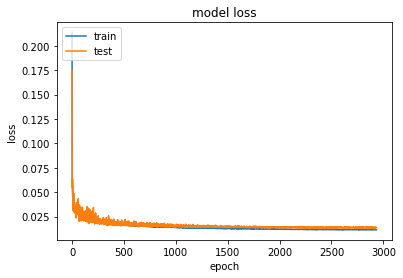

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_curves.png')
plt.show()

# Testing

In [15]:
y_predict = model.predict(x_test, batch_size=batch_size) 
y_predict_in_val = model.predict(x_val, batch_size=batch_size)
y_predict_in_train = model.predict(x_train, batch_size=batch_size)


Revert the Representation from normalize to lat-long coordinates

In [16]:
y_predict = scaler_y.inverse_transform(y_predict)
y_predict_in_train = scaler_y.inverse_transform(y_predict_in_train)
y_predict_in_val = scaler_y.inverse_transform(y_predict_in_val)
y_train = scaler_y.inverse_transform(y_train)
y_val = scaler_y.inverse_transform(y_val)
y_test = scaler_y.inverse_transform(y_test)

Calculate Haversine Error

In [17]:
print("Train set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'mean')))
print("Train set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'median')))
print("Train set75th perc error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'percentile',75)))
print("Val set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'mean')))
print("Val set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'median')))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'percentile',75)))
print("Test set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'mean')))
print("Test set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'median')))
print("Test set  75th perc. error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'percentile',75)))


Train set mean error: 100.84
Train set median error: 30.12
Train set75th perc error: 86.42
Val set mean error: 143.47
Val set median error: 46.82
Val set 75th perc.  error: 162.92
Test set mean error: 143.46
Test set median error: 45.86
Test set  75th perc. error: 160.53


In [18]:
test_error_list = calculate_pairwise_error_list(y_predict,y_test)
p.DataFrame(test_error_list).to_csv("mlp_test_error_list.csv")
print("Experiment completed!!!")

Experiment completed!!!


In [19]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("Baseline.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("Baseline.h5")